In [1]:
%matplotlib inline
from obspy.clients.fdsn.client import Client
from obspy.clients.fdsn.mass_downloader import GlobalDomain
from obspy.clients.fdsn.mass_downloader import MassDownloader
from obspy.clients.fdsn.mass_downloader import Restrictions
from obspy import UTCDateTime
from obspy.geodetics import calc_vincenty_inverse
from obspy.geodetics import locations2degrees
from obspy.taup import TauPyModel

from obspy.signal.invsim import cosine_sac_taper
from obspy.signal.util import _npts2nfft
import obspy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Getting the metadata of the station

Using IRIS web service, we can get the information and metadata about the `C0.EBRU` station which was installed in the Colorado School of Mines campus.

In [2]:
cl = Client()

inv = cl.get_stations(network="C0", station="EBRU", level="response")
inv.write("C0.EBRU.xml", format="StationXML") # writes the metadata as a StationXML file for safekeeping.
inv

Inventory created at 2022-11-27T11:19:23.145300Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?network=C0&station=E...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			C0
		Stations (1):
			C0.EBRU (Test station at Colo School of Mines)
		Channels (11):
			C0.EBRU..BHZ, C0.EBRU..BH1, C0.EBRU..BH2, C0.EBRU..HHZ (2x), 
			C0.EBRU..HH1 (2x), C0.EBRU..HH2 (2x), C0.EBRU..LOG (2x)

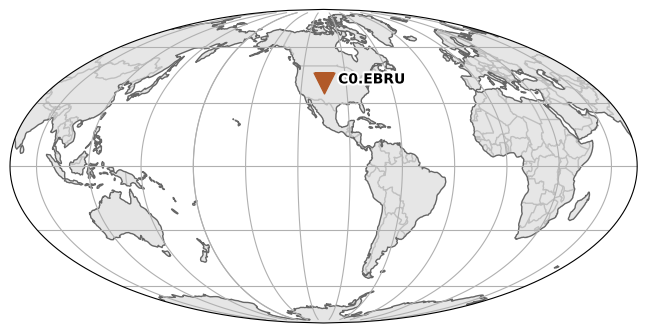

In [3]:
inv.plot();

## Data Availability
We can determine the dates which the data is available from this station by printing out the operating dates of the station.

In [4]:
print("|-------------+----------------+---------------|")
print("| Channel     |  Start Date    |  End Date     |")
print("|-------------+----------------+---------------|")
for network in inv:
    for station in network: 
        for channel in station:
            print(f"| {network.code}.{station.code}.{channel.code} | ",
                  channel.start_date.strftime("%b %d, %Y"), " | ", channel.end_date.strftime("%b %d, %Y"), "|")
print("|-------------+----------------+---------------|")

|-------------+----------------+---------------|
| Channel     |  Start Date    |  End Date     |
|-------------+----------------+---------------|
| C0.EBRU.BH1 |  Sep 28, 2020  |  Oct 12, 2020 |
| C0.EBRU.BH2 |  Sep 28, 2020  |  Oct 12, 2020 |
| C0.EBRU.BHZ |  Sep 28, 2020  |  Oct 12, 2020 |
| C0.EBRU.HH1 |  Sep 28, 2020  |  Oct 13, 2020 |
| C0.EBRU.HH1 |  Nov 08, 2021  |  Nov 23, 2021 |
| C0.EBRU.HH2 |  Sep 28, 2020  |  Oct 13, 2020 |
| C0.EBRU.HH2 |  Nov 08, 2021  |  Nov 23, 2021 |
| C0.EBRU.HHZ |  Sep 28, 2020  |  Oct 13, 2020 |
| C0.EBRU.HHZ |  Nov 08, 2021  |  Nov 23, 2021 |
| C0.EBRU.LOG |  Sep 28, 2020  |  Oct 13, 2020 |
| C0.EBRU.LOG |  Nov 08, 2021  |  Nov 23, 2021 |
|-------------+----------------+---------------|


# Selecting an earthquake

We can now search for suitable earthquakes for the selected date range.

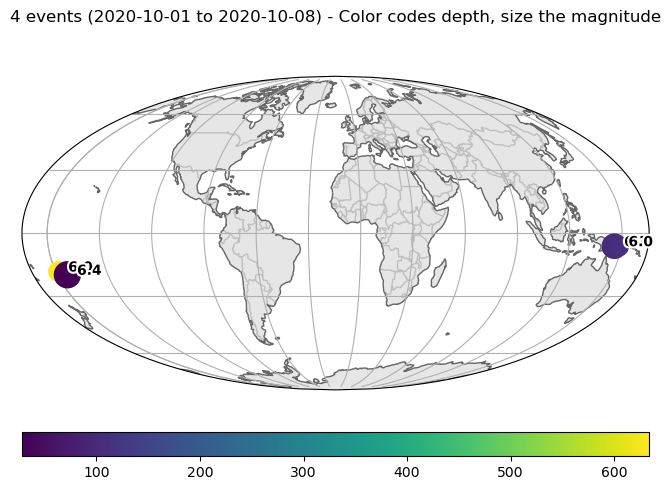

4 Event(s) in Catalog:
2020-10-08T07:35:32.224000Z |  -6.114, +146.169 | 6.3  Mww
2020-10-06T10:11:46.688000Z | -18.010, -178.476 | 6.0  Mww
2020-10-01T10:34:48.481000Z |  -6.087, +148.658 | 6.0  mww
2020-10-01T01:13:36.524000Z | -19.538, -174.122 | 6.4  Mww


In [5]:
t1 = UTCDateTime("2020-09-28T00:00:00")
t2 = UTCDateTime("2020-10-13T00:00:00")
# t1 = UTCDateTime("2021-11-08T00:00:00")
# t2 = UTCDateTime("2021-11-23T00:00:00")
cat = cl.get_events(starttime=t1, endtime=t2, minmagnitude=6.0)
cat.plot()
print(cat)

We can decide for an earthquake to investigate. Here by default 4th earthquake is selected.

In [6]:
event = cat[3]
origin = event.preferred_origin()

sta_coords = inv.get_coordinates("C0.EBRU..BHZ") # gets the coordinates of the station
sta_lat = sta_coords["latitude"]
sta_lon = sta_coords["longitude"]

dist_m, az, baz = calc_vincenty_inverse(
    origin.latitude, origin.longitude, sta_lat, sta_lon
) # calculates the distance between earthquake and the station in meters, azimuth and back azimuth
dist_deg = dist_m/1000/111.111
print(f"Distance: {dist_deg:.2f} deg")

Distance: 87.26 deg


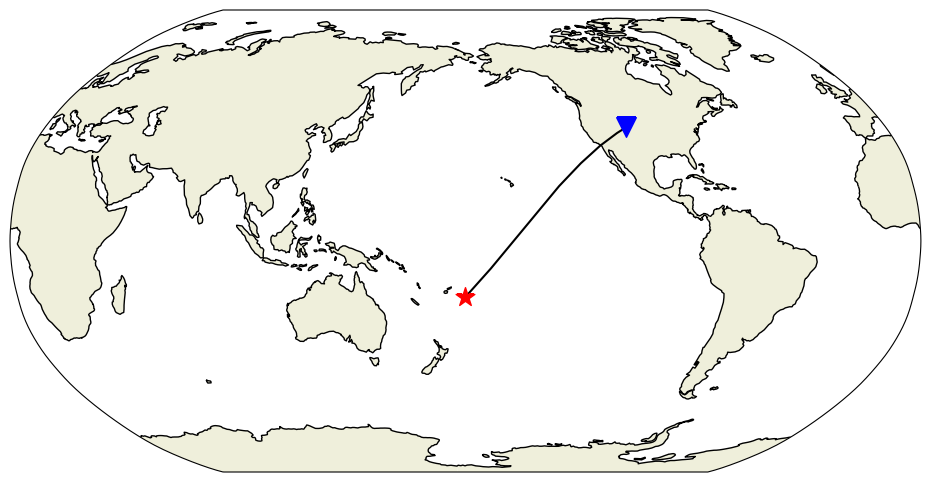

In [7]:
fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=origin.longitude)),
)
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax.scatter(origin.longitude, origin.latitude, 200,
           marker="*", color="red", transform=ccrs.PlateCarree(), zorder=100)
ax.scatter(sta_lon, sta_lat, 200, 
           marker="v", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.plot([origin.longitude, sta_lon], [origin.latitude, sta_lat], "k",
        transform=ccrs.Geodetic()); # plots the ray path

# Getting the Waveform Data

We can get the waveform data by specifying a time range. Here by default range is selected to start from earthquake origin time and end after 60 minutes.

In [8]:
st = cl.get_waveforms(network="C0", station="EBRU", location="", channel="*", starttime=origin.time, endtime=origin.time+60*60)

In [9]:
st.write("C0.EBRU.mseed", format="mseed") # save the data for safe keeping

In [10]:
st = obspy.read("C0.EBRU.mseed") # read the data from the disk

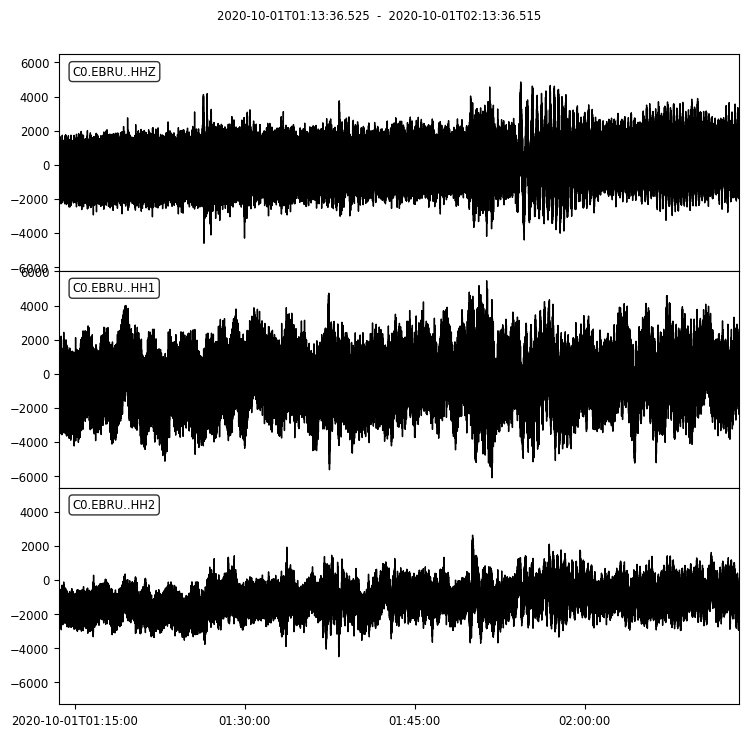

In [11]:
st.plot();

# Processing the data

We can now remove the instrument response of the station and filter the data.

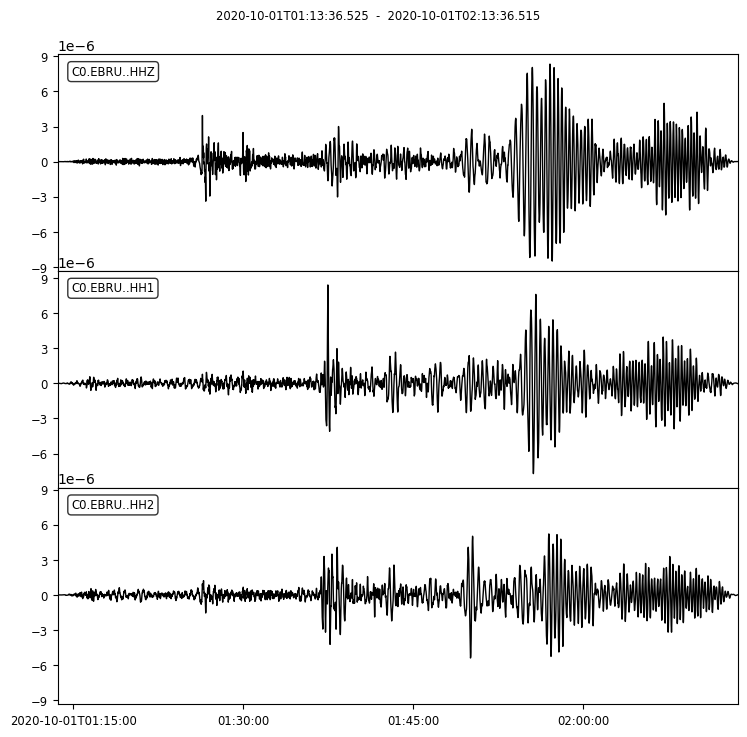

In [12]:
st.detrend("demean")
st.detrend("linear")
st.taper(0.05)

min_period = 1.0
max_period = 30.0

pre_filt = [
    0.8 * (1 / max_period),
    1 / max_period,
    1 / min_period,
    1.2 * (1 / min_period),
]

st.attach_response(inv)
st.remove_response(output="DISP", pre_filt=pre_filt,  plot=False)
st.plot();

We can also rotate the horizontal seismograms to radial and tranverse components.

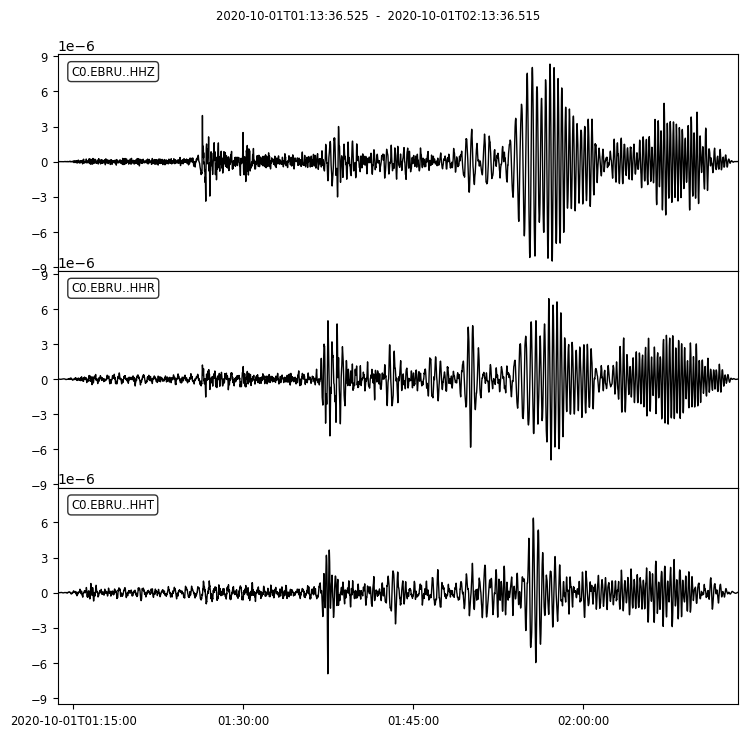

In [13]:
st.rotate("->ZNE", inventory=inv) # This ensures using North-South, East-West components
st.rotate("NE->RT", back_azimuth=baz)
st.plot();

# Looking at specific phases

P phase arrival at 764.087 seconds
S phase arrival at 1402.745 seconds


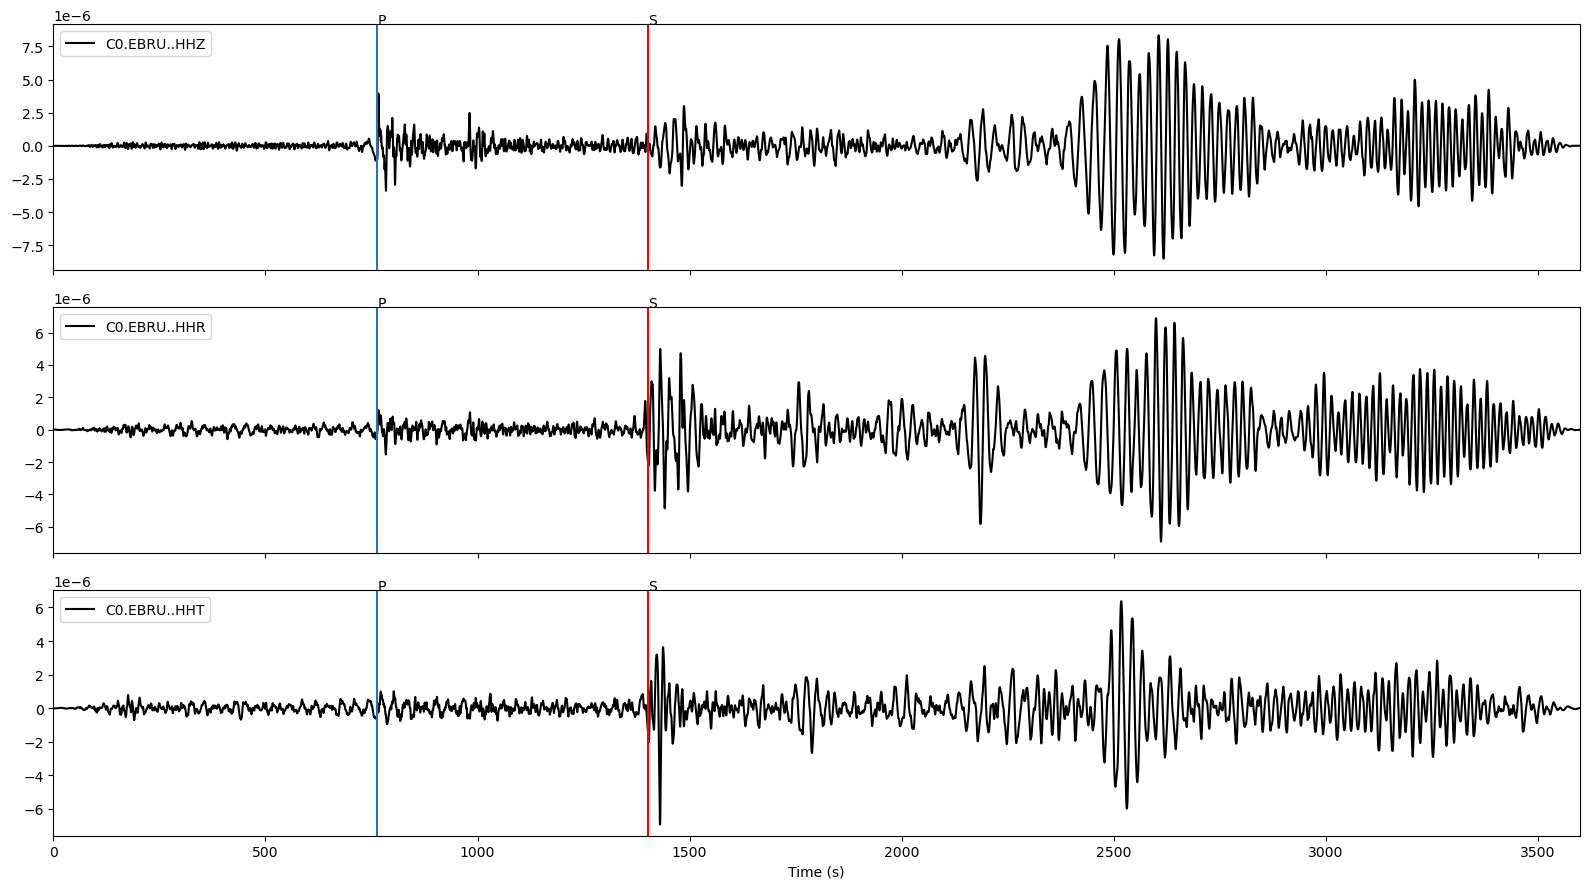

In [14]:
taup_model = TauPyModel("iasp91")
arrivals = taup_model.get_travel_times_geo(
    origin.depth / 1000, origin.latitude, origin.longitude, sta_lat, sta_lon, phase_list=("P", "S")
)
for arrival in arrivals:
    print(arrival)

arr = arrivals[0]
arr2 = arrivals[1]
fig, axes = plt.subplots(figsize=(16, 9), nrows=3, sharex=True)

for ax, tr in zip(axes, st):
    ax.plot(tr.times(), tr.data, "k", label=tr.id)
    ax.axvline(arr.time)
    ax.text(arr.time, ax.get_ylim()[1], arr.name)
    ax.axvline(arr2.time, color="r")
    ax.text(arr2.time, ax.get_ylim()[1], arr2.name)
    ax.legend(loc="upper left")
    
ax.set_xlim(tr.times()[0], tr.times()[-1])
ax.set_xlabel("Time (s)")
fig.tight_layout()

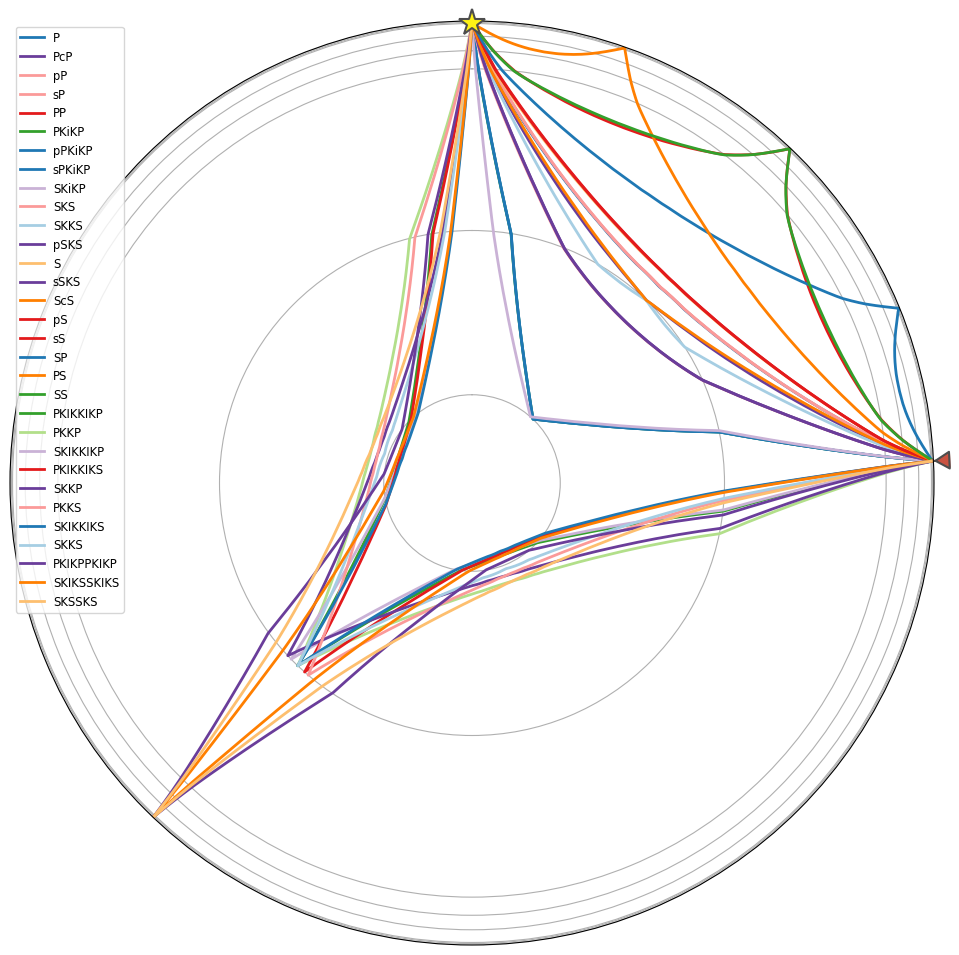

In [15]:
ray_paths = taup_model.get_ray_paths(origin.depth/1000,  dist_deg, phase_list=("ttall", ))
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

ray_paths.plot_rays(ax=ax, legend=True);